# PCA, Linear Regression, and Regularization
By Adam Hollander

## Get Data

In [11]:
# Import Libraries Used
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, mutual_info_regression
import matplotlib.pyplot as plt
import time
import numpy as np
import itertools
import heapq
import collections
import seaborn as sns
import pandas as pd

# Load Dataset
file_name = 'who.csv'
data = pd.read_csv(file_name)

# Select columns used as features
columns_of_interest = np.array([
    'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 
    'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 
    'HIV/AIDS', 'GDP', 'Population', 'thinness1-19', 'thinness5-9', 
    'Income composition of resources', 'Schooling', 'Life expectancy'
])
feature_indeces = {feature: i for i, feature in enumerate(columns_of_interest)}

# Select features and output (For data analysis)
columns_of_interest_with_output = np.append(columns_of_interest, ['Life expectancy'])

# Select columns and drop all missing rows with missing data and retrieve output 
data = data[columns_of_interest]
data = data.dropna()
all_data = data[columns_of_interest_with_output]
print(all_data.shape)
output = data['Life expectancy']

(1649, 19)


## Normalize Data

In [124]:
# Scale the data (i.e normalize and establish mean of 0)
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=columns_of_interest)

## Visualize Data

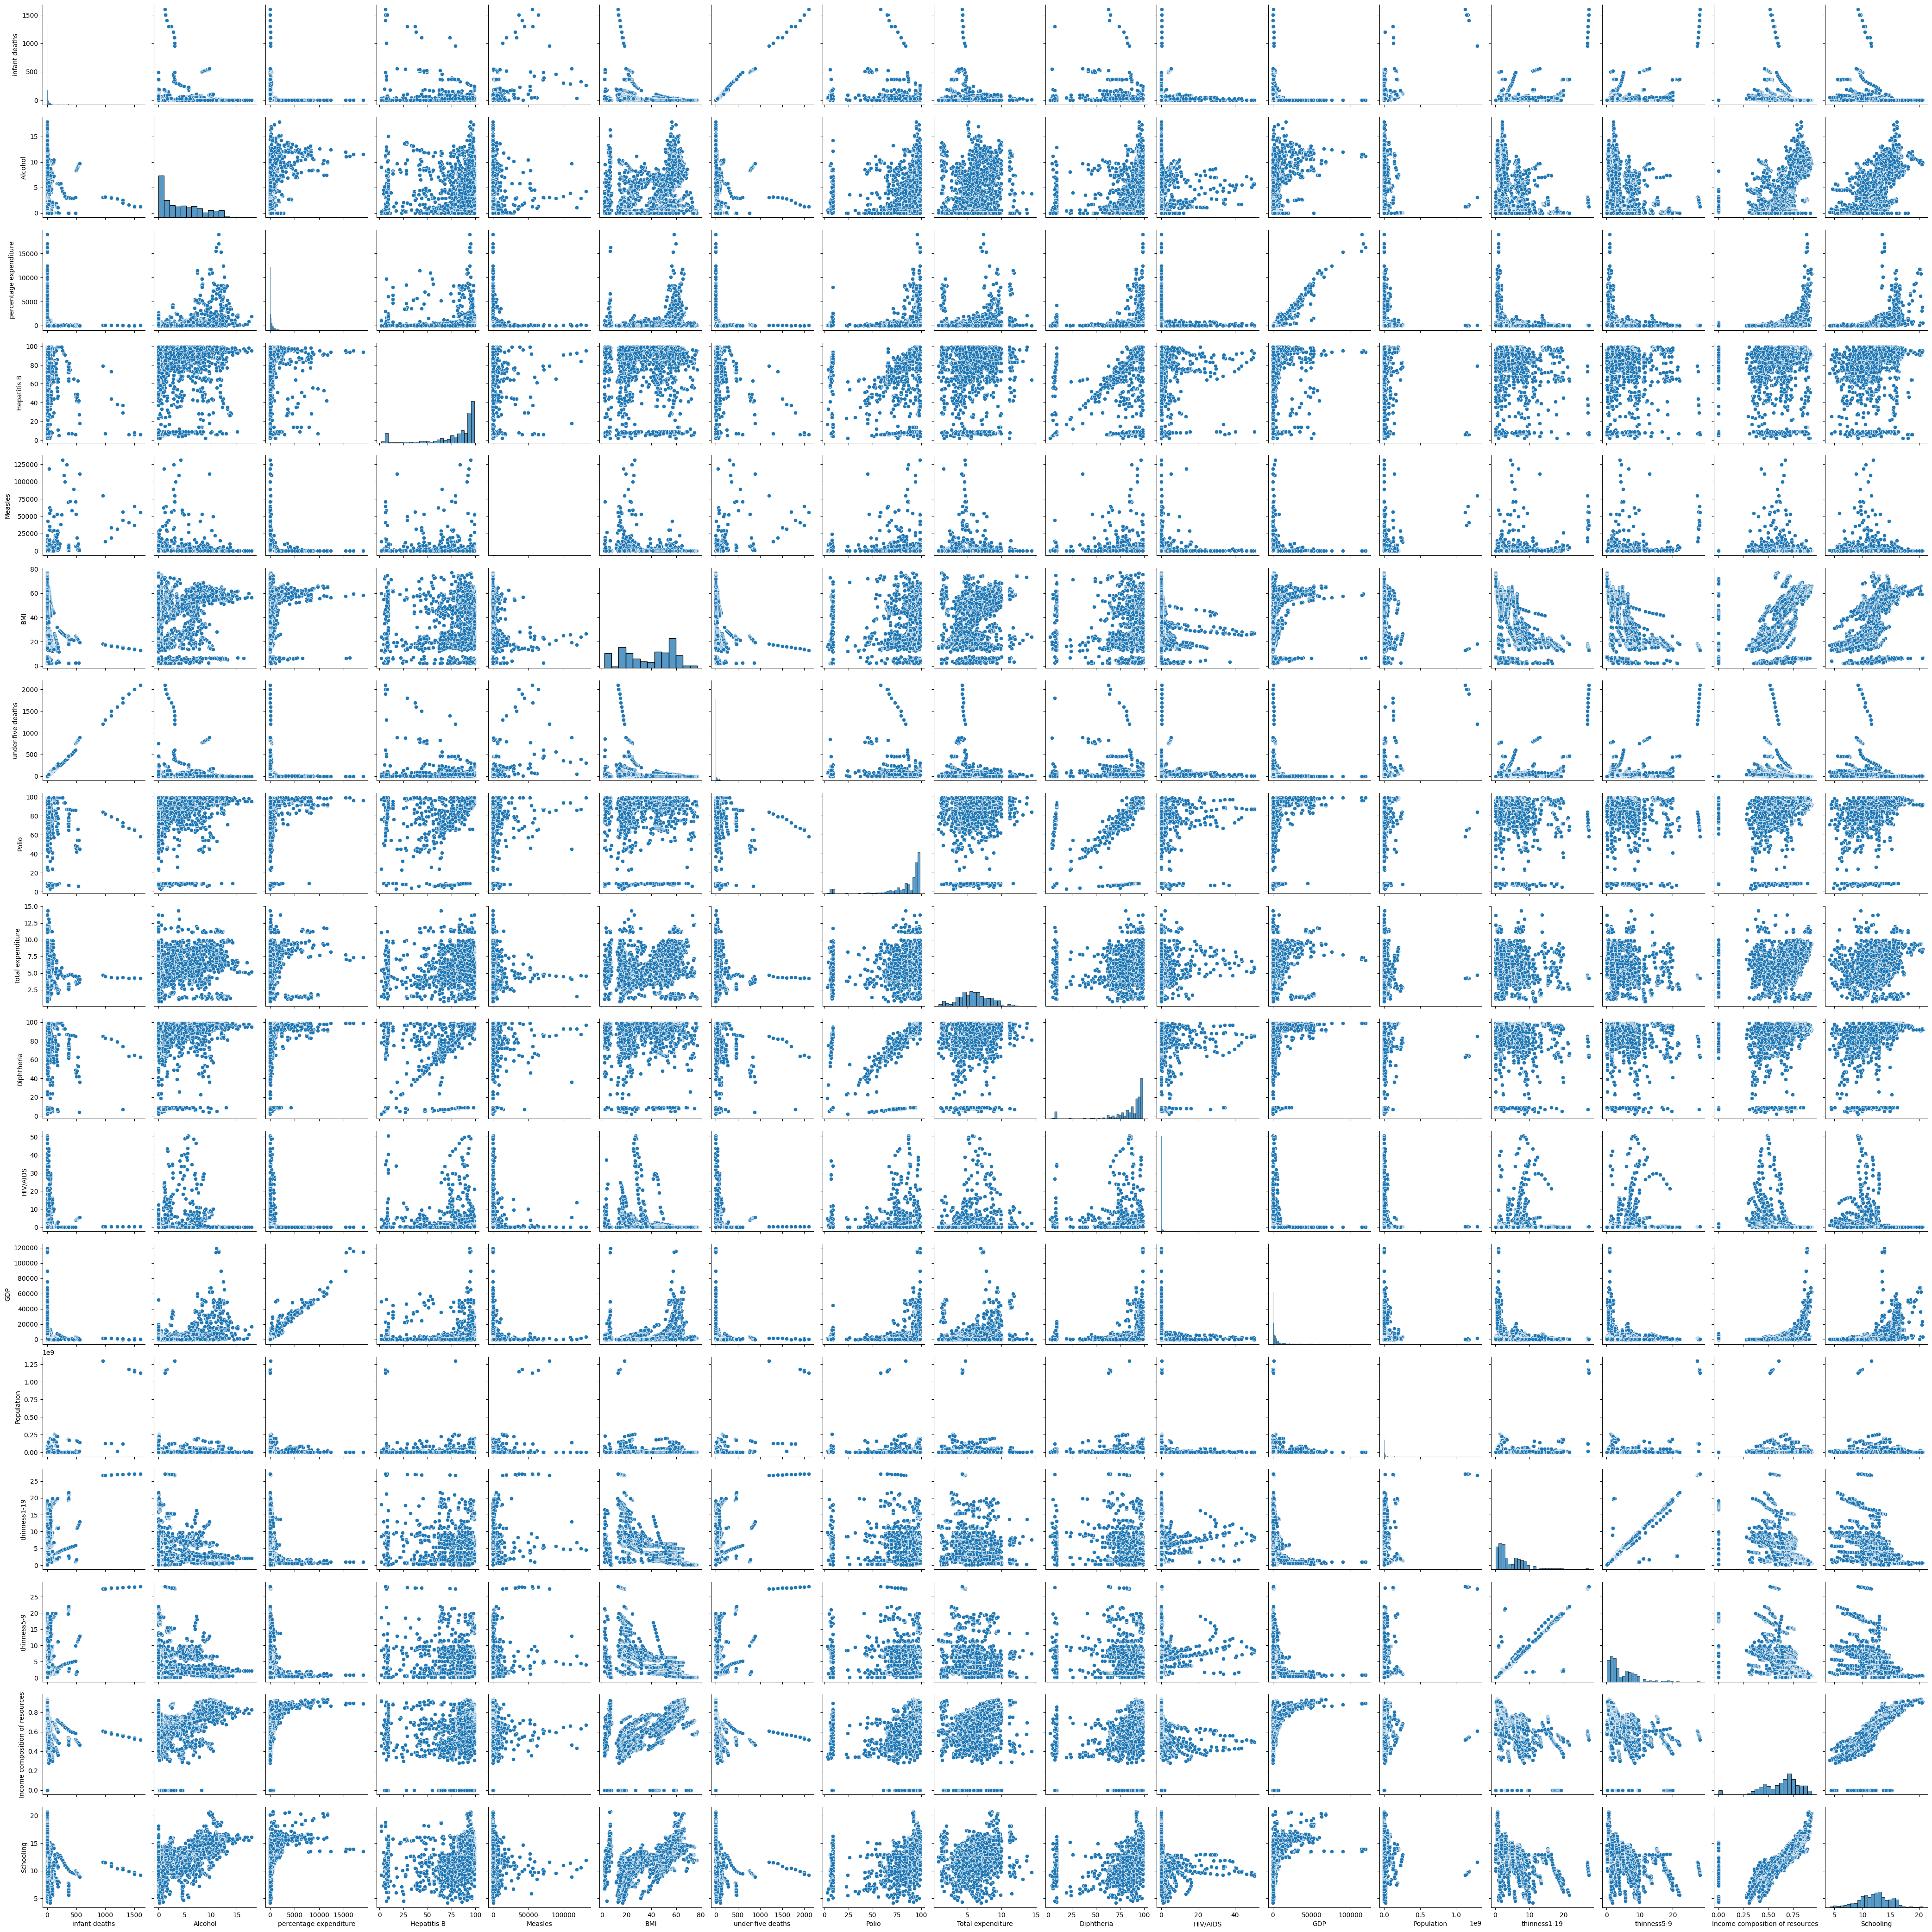

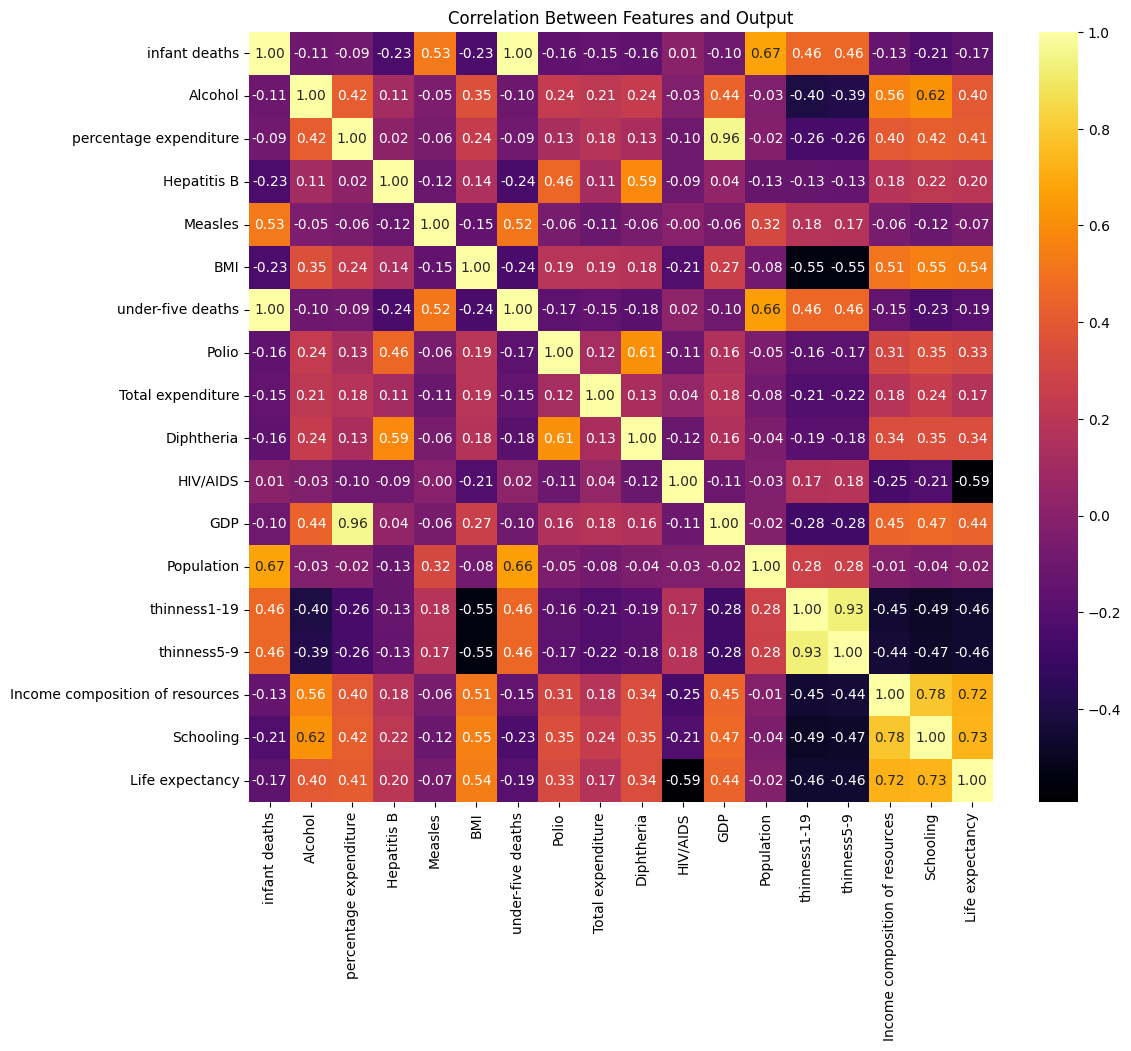

In [134]:
# Visualize relationships between all features/outputs (unscaled)
df = pd.DataFrame(all_data, columns=data.columns)
sns.pairplot(df)
plt.show()

# Display the correlation values between all features/outputs (unscaled)
data_correlation = pd.DataFrame(all_data, columns=columns_of_interest_with_output).corr()
plt.figure(figsize=(12, 10))
plt.title("Correlation Between Features/Output")
sns.heatmap(data_correlation, annot=True, cmap='inferno', fmt=".2f")
plt.show()

## Utility Functions

In [137]:
def plot_features_over(x_values, feature_mat, x_ax_name, title):
  '''
  Display a table illustrating whether features are selected under a particular condition/circumstance

  Parameters:
  - x_values (list): Different parameters/conditions under which each corresponding group of features are selected
  -feature_mat (list): Matrix containing the features selected for each corresponding parameter/condition
  - x_ax_name (string): Name of the condition/circumstance changing for each selection
  - title (string): Title of the plot
  '''

  # Initialize a binary matrix with rows representing all features and columns being the number of distinct x values
  feature_table = np.zeros((len(columns_of_interest), len(x_values)))

  # For each group of features selected, set their respective values to 1 for their x value
  for i, features in enumerate(feature_mat):
    for feature in features:
      feature_table[feature_indeces[feature], i] = 1

  # Display a binary plot illustrating the features selected in each case
  plt.imshow(feature_table, cmap='binary', aspect='auto')
  plt.yticks(range(len(columns_of_interest)), columns_of_interest, size='small')
  plt.xticks(range(len(x_values)),x_values, rotation=45)
  plt.title(title)
  plt.xlabel(x_ax_name)
  plt.ylabel('Feature')
  plt.show()

def regress_test(data, output):
  '''
  Perform linear regression using provided input and output values and calculate test performance

  Parameters:
  - data (matrix): Input features for all samples
  - output (list): Output values corresponding to each sample

  Returns:
  - float: Mean squared error of the trained model
  '''
  # Split the train and test data (0.2 test 0.8 train)
  train_in, test_in, train_out, test_out = train_test_split(data, output, test_size=0.2)

  # Initialize and train the regression algorithm
  regress = LinearRegression().fit(train_in, train_out)

  # Calculate the mean squared error of the test data and return
  predictions = regress.predict(test_in)
  return mean_squared_error(predictions, test_out)

def plot_data(x, y, x_ax_label, y_ax_label, title):
  '''
  Create a line plot of the provided data

  Parameters:
  - x (list): X values for each point plotted
  - y (list): Corresponding y values for each respective x
  - x_ax_label (string): Label to be displayed along the x axis
  - y_ax_label (string): Label to be displayed along the y axis
  - title (string): Title to be displayed at the top of the plot
  '''
  plt.plot(x, y)
  plt.xlabel(x_ax_label)
  plt.ylabel(y_ax_label)
  plt.title(title)
  plt.show()

def biplot(component_coeff, feature_names, components):
  '''
  Construct a biplot illustrating each feature projected onto the space formed by the specified 2 principal components

  Parameters:
  - component_coeff (matrix): Matrix with rows as the weight applied to that particular feature 
                              and with columns that are as each successive principal component
  - feature_names (list): List of feature names (in same order as those used in the principal components)
  - components (list): List containing the 2 principal components to be used to project
  '''

  # Initialize colors for each of the 18 features
  biplot_colors = ['red', 'darkorange', 'firebrick', 'lime', 'aqua', 'darkgreen', 'teal', 'gold', 'slategrey',
                    'navy', 'lightcoral', 'blue', 'rebeccapurple', 'violet', 'deeppink', 'darkgoldenrod', 'black']
  plt.figure(figsize=(8, 8))

  # For each of the features
  for i in range(len(component_coeff)):
      # Plot the vector formed by the corresponding values for that feature in the specified principal components and label it
      x = component_coeff[i,components[0]] * 2
      y = component_coeff[i,components[1]] * 2
      plt.arrow(0, 0, x, y, color=biplot_colors[i], alpha=0.5, label=feature_names[i])
      plt.text(x, y, feature_names[i], color=biplot_colors[i], ha='center', va='center', fontsize=10)
  
  # Initialize the plot labels and show it
  plt.xlabel(f"Principal Component {components[0] + 1}")
  plt.ylabel(f"Principal Component {components[1] + 1}")
  plt.axhline(0, color='k', linestyle='--', linewidth=0.5)
  plt.axvline(0, color='k', linestyle='--', linewidth=0.5)
  plt.title(f"Biplot of Features in 2D Space Formed by components {components[0] + 1} and {components[1] + 1}")
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.show()

def plot_loadings_heatmap(feature_values, feature_names):
  '''
  Displays a heatmap of the values corresponding to each feature for each principal component

  Parameters:
  - feature_values (matrix): Matrix with rows as principal components and columns corresponding to the value of that principal component
                             for each feature
  - feature_names (list): Feature names in the order they are used in the principal components
  '''
  # Plot the heat map of each of the feature values in each of the principal components
  plt.figure(figsize=(10, 6))
  plt.imshow(feature_values, cmap='inferno', aspect='auto')
  plt.colorbar(label='Value')

  # Format and label the plot
  plt.xticks(np.arange(len(feature_names)), feature_names, rotation=45, ha='right')
  plt.xlabel('Feature')
  plt.ylabel('Principal Component')
  plt.title('Heatmap of Feature Values In Each Principal Component')
  plt.tight_layout()
  plt.show()



## Regression + PCA

In [138]:
# All possible numbers of principal components for the dataset
test_components = np.arange(1, data.shape[1] + 1)

# Initialize for data analysis
scores = []
times = []
pca_regress = None

# For each of the possible numbers of principal components
for n_comp in test_components:
  start_time = time.time()

  # Run PCA using the current number of components on the data
  pca_regress = PCA(n_components=n_comp)
  pca_regress_reduction = pca_regress.fit_transform(data)

  # Run regression using the transformed data
  scores.append(regress_test(pca_regress_reduction, output))
  times.append(time.time() - start_time)

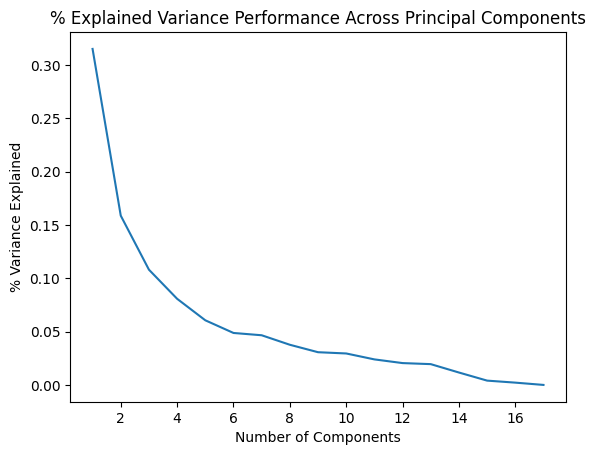

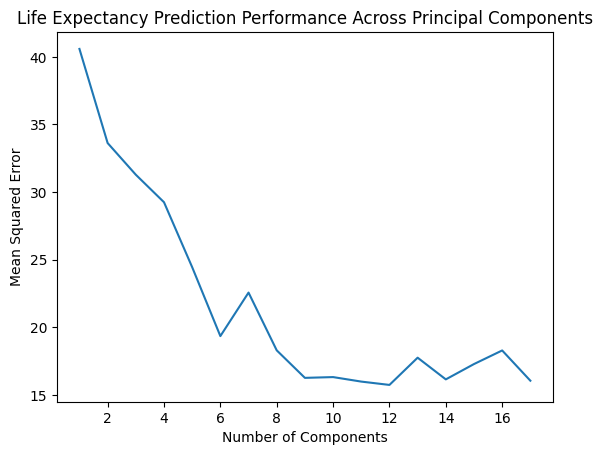

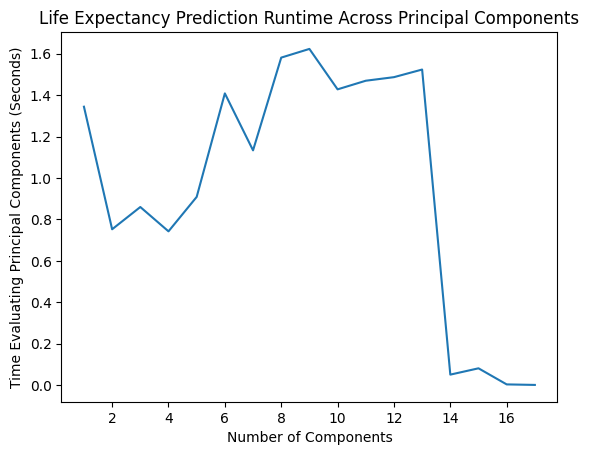

In [135]:
# Plot the variance explained for each principal component
plot_data(test_components, pca_regress.explained_variance_ratio_, 'Number of Components', '% Variance Explained', 
          '% Explained Variance Performance Across Principal Components')

# Plot the regression performance on input transformed using increasing principal components
plot_data(test_components, scores, 'Number of Components', 'Mean Squared Error', 
          'Life Expectancy Prediction Performance Across Principal Components')

# Plot the PCA and regression runtime using each possible number of principal components
plot_data(test_components, times, 'Number of Components', 'Time Evaluating Principal Components (Seconds)', 
          'Life Expectancy Prediction Runtime Across Principal Components')

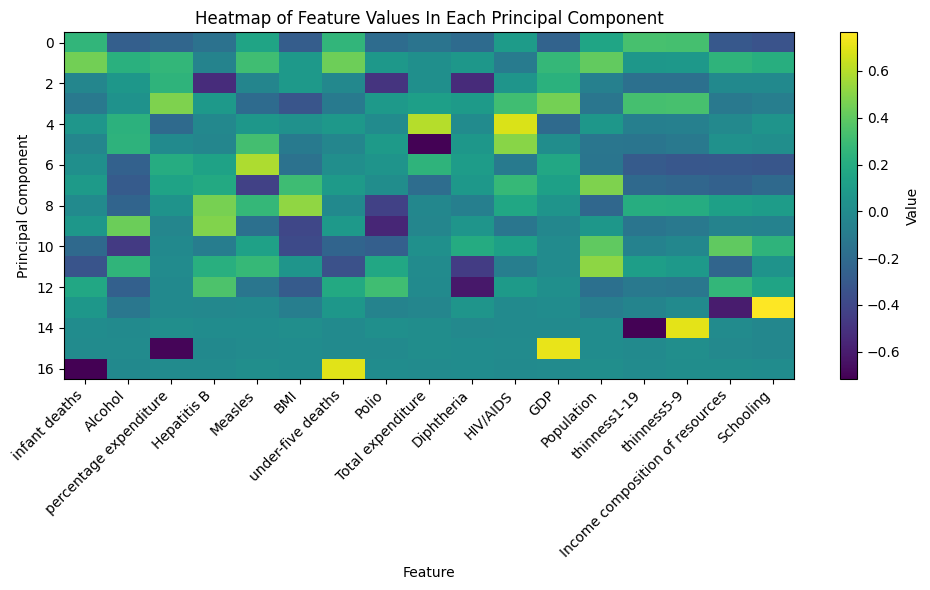

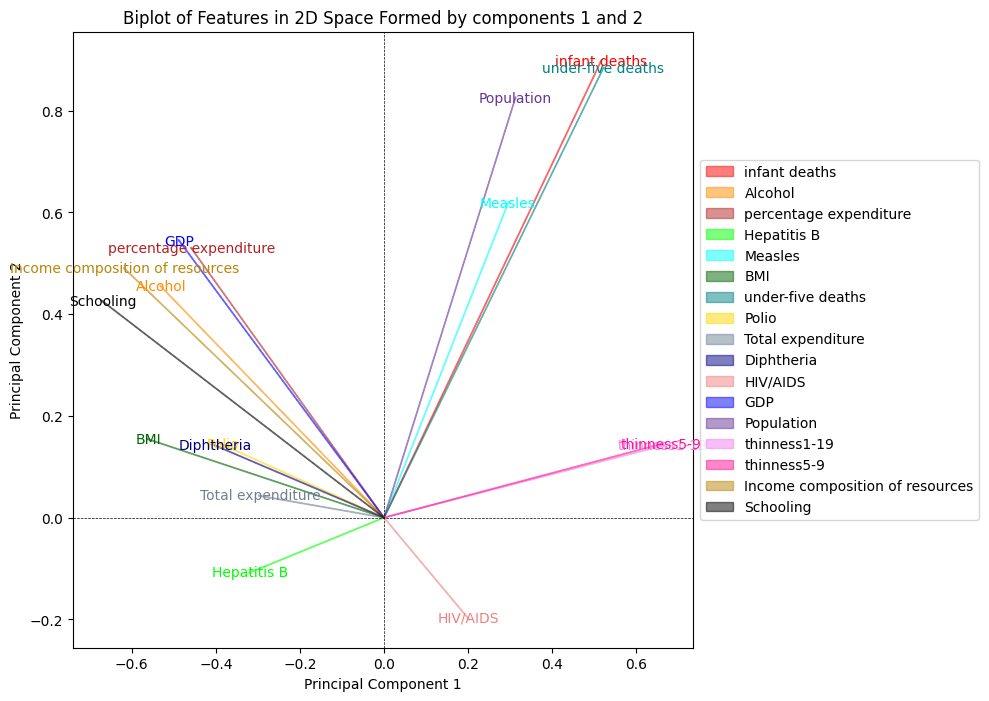

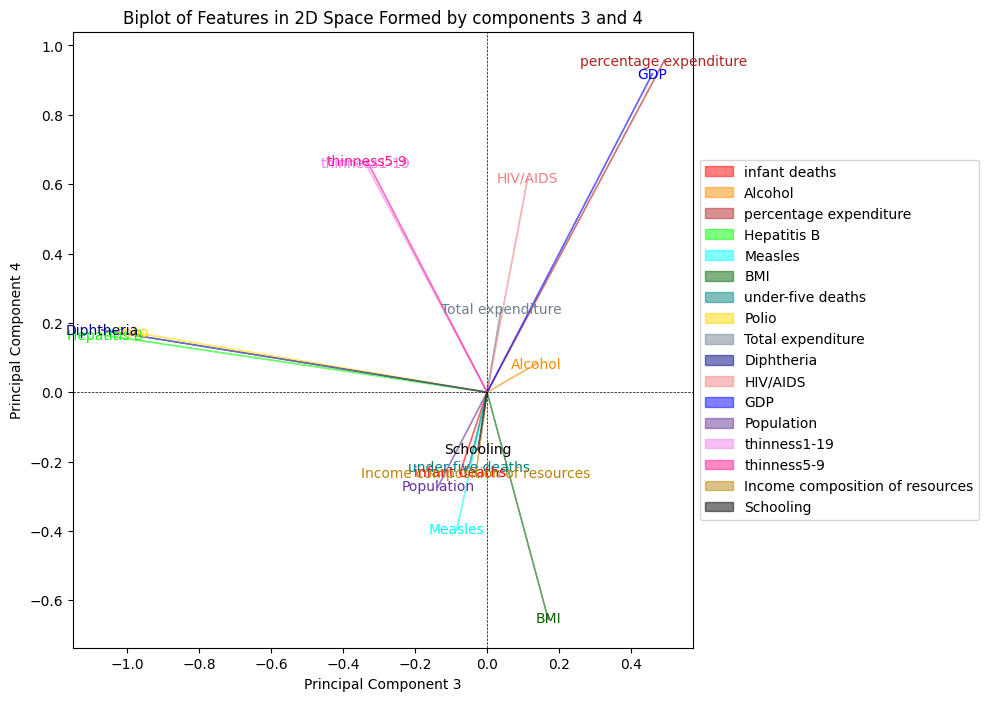

In [139]:
# Set the total number of components equal to the number of features
num_components = data.shape[1]
pca = PCA(n_components=num_components)

# Run PCA and display those components on a heatmap
pca_reduction = pca.fit_transform(data)
plot_loadings_heatmap(pca.components_, feature_names=columns_of_interest)

# Display biplot using the first 4 principal components
biplot(pca.components_.T, columns_of_interest, [0, 1])
biplot(pca.components_.T, columns_of_interest, [2, 3])


## Standard Regression

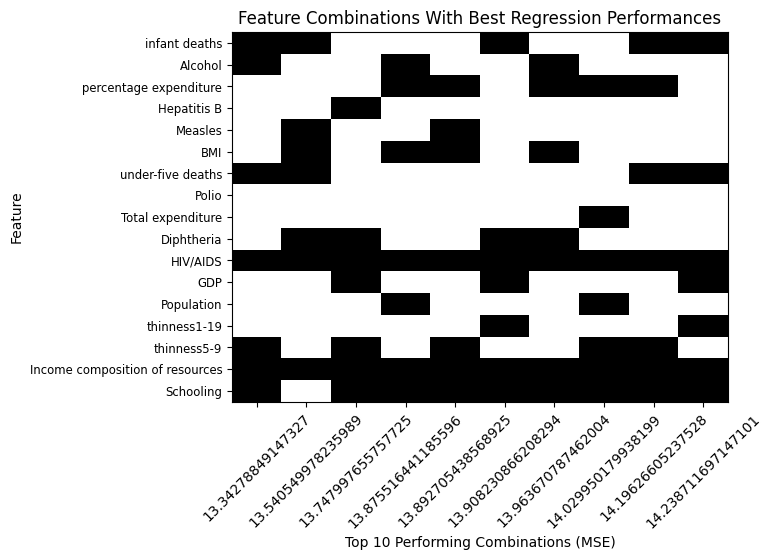

Most common 5 features among the 10 best performing feature combinations Counter({'HIV/AIDS': 10, 'Income composition of resources': 10, 'Schooling': 9, 'infant deaths': 5, 'thinness5-9': 5, 'percentage expenditure': 5, 'under-five deaths': 4, 'BMI': 4, 'Diphtheria': 4, 'Alcohol': 3, 'GDP': 3, 'Measles': 2, 'Population': 2, 'thinness1-19': 2, 'Hepatitis B': 1, 'Total expenditure': 1})


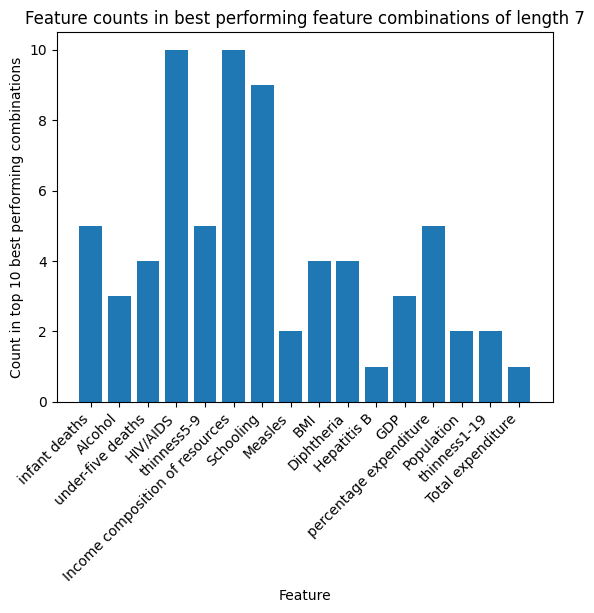

In [141]:
# Find all combinations of features of a particular length
feature_combination_length = 7 
features = np.arange(data.shape[1])
combinations = list(itertools.combinations(features, feature_combination_length))
h = []

# For each of the feature combinations from above
for index, feature_group in enumerate(combinations):
  # Perform regression using those features
  cur_score = regress_test(data[columns_of_interest[list(feature_group)]], output)

  # Add the feature combination performance to a heap that maintains the top 10 performing combinations
  heapq.heappush(h, [-cur_score, list(feature_group)])
  if len(h) > 10:
    heapq.heappop(h)

# Sort the best performing combinations based on their performances
h.sort(key=lambda x: -x[0])

# Extract the best performing feature combinations and performance values
top_feature_combinations = np.array(list(map(lambda x: columns_of_interest[x], [res[1] for res in h])))
top_MSE_values = [-res[0] for res in h]

# Depict the best performing combinations and the most prevalent features among those combinations
plot_features_over(top_MSE_values, top_feature_combinations, "Top 10 Performing Combinations (MSE)", "Feature Combinations With Best Regression Performances")

feature_counts = collections.Counter(top_feature_combinations.flatten())
plt.bar(feature_counts.keys(), feature_counts.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Count in top 10 best performing combinations')
plt.title(f'Feature counts in best performing feature combinations of length {feature_combination_length}')
plt.show()

## Regularization

In [131]:
# Split train and test data
train_in, test_in, train_out, test_out = train_test_split(data, output, test_size=0.2)

# Perform lasso (l1) regression on the train data
regularization_model = Lasso()
regularization_model.fit(train_in, train_out)

# Evaluate the MSE and find significant (i.e nonzero) features
regularization_predictions = regularization_model.predict(test_in)
regularization_nonzero_coefs = np.nonzero(regularization_model.coef_)
print(f'Regularization test MSE: {mean_squared_error(regularization_predictions, test_out)}')
print(f'Features with nonzero coefficients after regularization: {columns_of_interest[regularization_nonzero_coefs]}')


Regularization test MSE: 20.893240173864807
Features with nonzero coefficients after regularization: ['BMI' 'HIV/AIDS' 'Income composition of resources' 'Schooling']


## Wrapper Feature Selection Technique

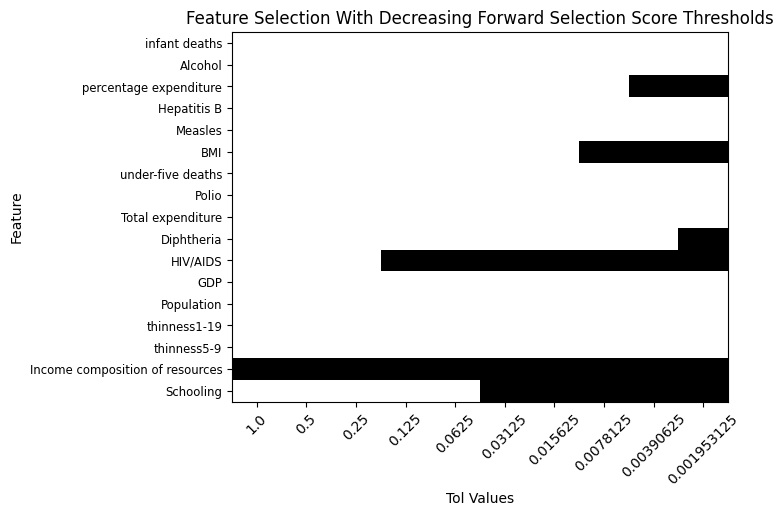

In [142]:
# Initialize tol values to be used with forward selection
tol_vals = [1/2**i for i in range(0, 10)]
wrapper_features_selected = []

# For each of the tol values experimented with
for t in tol_vals:
  # Perform forward selection using linear regression
  forward_reg = LinearRegression()
  forward_select = SequentialFeatureSelector(forward_reg, direction='forward', tol=t)
  forward_select.fit(data, output)

  # Get the selected features using the current parameter configuration
  features = forward_select.get_feature_names_out(columns_of_interest)
  wrapper_features_selected.append(features)

# Plot the features selected for each of the attempted tol values
plot_features_over(tol_vals, wrapper_features_selected, 'Tol Values', "Feature Selection With Decreasing Forward Selection Score Thresholds")

## Filter Feature Selection Technique

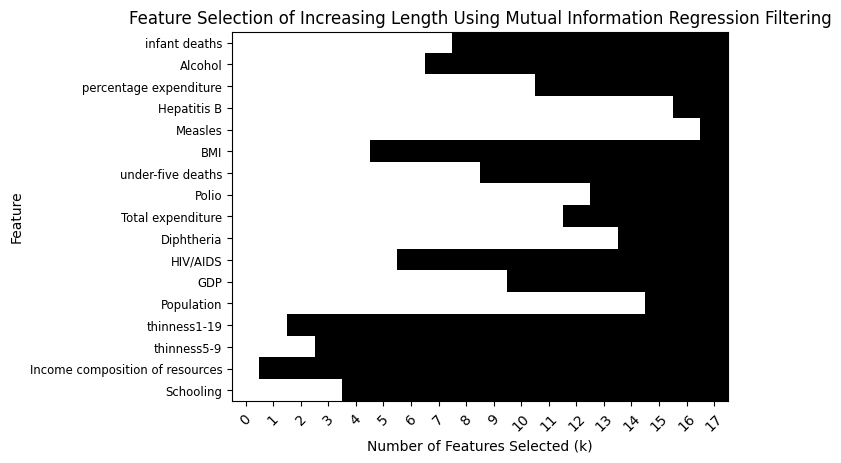

In [133]:
filter_features_selected = []

# For all possible feature selection lengths
for k in range(data.shape[1] + 1):
  # Find the current best k features using mutual info regression
  mutual_info_select = SelectKBest(score_func=mutual_info_regression, k=k)
  mutual_info_select.fit(data, output)
  filter_features_selected.append(mutual_info_select.get_feature_names_out(columns_of_interest))

# Plot those features selected using all values of k
plot_features_over(np.arange(data.shape[1] + 1), filter_features_selected, "Number of Features Selected (k)", "Feature Selection of Increasing Length Using Mutual Information Regression Filtering")